# Intro
In this report, we look at left hemisphere MANIA 1.0 results for seven HCP subjects with MMP1.0 parcellation

### Operating Point
Let's first look at **(density, threshold, NAR)** operating points. On the scatter plot, you can hover to see the NAR information. NARs are scaled by 100 for visualization purposes.

In [1]:
from py2neo import Node, Relationship, Graph
from numpy.random import rand
import numpy as num
from bokeh.plotting import output_notebook,figure,ColumnDataSource, show
from bokeh.layouts import row,column,gridplot
from bokeh.models import HoverTool
from utils import *
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### JACCARD SIMILARITY
Next we look at the jaccard similarity between each pair of subject networks

In [3]:
# NEO4J database call for results
graph = Graph()
c1 = '''MATCH (:MANIA)-[r:SUB]-(n:RES)
 return r.id as sub, n.threshold as t,n.density as d,n.NAR as nar'''
A = graph.run(c1)
# Plotting the data
s = []
hover = HoverTool(tooltips=[
    ("NAR", "$NAR"),
    ("SUBJECT", "$SUB"),
])
sub = []
t = []
d = []
nar = []
for i,w in enumerate(A):
    sub = sub + [w['sub']]
    nar = nar + [w['nar']*100]
    d = d + [w['d']*100]
    t = t + [w['t']]
source = ColumnDataSource(data=dict(
    sub=sub,
    t=t,
    d=d,
    nar=nar
))
hover = HoverTool(tooltips=[
    ("NAR", "@nar"),
    ("SUBJECT", "@sub"),
])
p = figure(plot_width=500, plot_height=500, tools=[hover],title="MANIA 1.0 Operating points",y_axis_label = "density",x_axis_label = "threshold")
p.circle('t', 'd', size=20, source=source)
show(p)

In [9]:
c1 = '''MATCH (n:ROI)-[r:MANIA{connected:1}]->(m:ROI)
 return n.name as N1,m.name as N2,r.SUB as sub'''
A = graph.run(c1)
net = {}
E = {}
for w in A:
    try:
        E[w['N1']+w['N2']] += 1
    except KeyError:
        E[w['N1']+w['N2']] = 1
    i = int(w['N1'][1:])-1
    j = int(w['N2'][1:])-1
    try:
        net[w['sub']][i,j] = 1
    except KeyError:
        net[w['sub']]=num.zeros((180,180))
from itertools import combinations
S = sorted(net.keys())
A =  num.zeros((7,7))
for i in range(7):
    A[i,i] = 1.0
Z = []
for w,v in combinations(S,2):
    tmp = sim(net[w],net[v])
    A[S.index(w),S.index(v)] = tmp
    A[S.index(v),S.index(w)] = tmp
    Z = Z + [tmp]
from collections import Counter
c = Counter(list(E.values()))
per = []
K=[]
for v in c:
    per = per + [int(c[v]*100/len(E))]
    K = K + [v]
cc = sorted(zip(K,per),reverse=True)
per = [xx[1] for xx in cc]
K = [xx[0] for xx in cc]

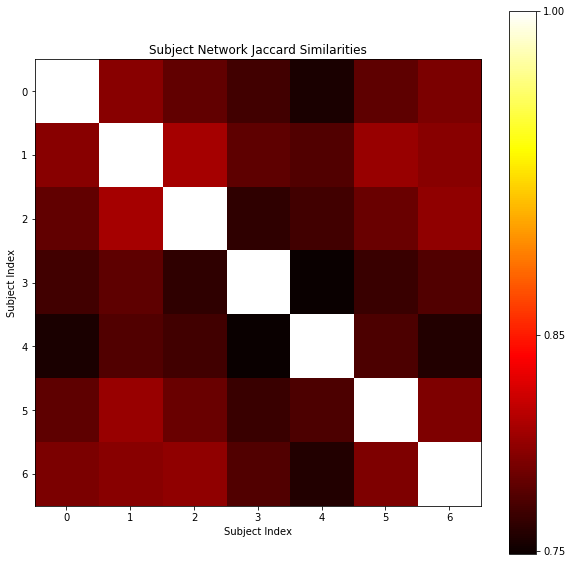

In [30]:
plt.figure(figsize=(10, 10))
cax = plt.imshow(A, cmap='hot', interpolation='nearest')
plt.title("Subject Network Jaccard Similarities")
plt.xlabel("Subject Index")
plt.ylabel("Subject Index")
cbar = plt.colorbar(cax, ticks=[0.75, 0.85, 1], orientation='vertical')
cbar.ax.set_xticklabels(['0.75', '0.85', '1'])  # horizontal colorbar
plt.show()

| Subject 1        | Subject2           | Jaccard Similarity (100%)  |
| ------------- |:-------------:| -----:|
| 0| 1 |80.0  |
| 0| 2 |79.0  |
| 0| 3 |77.0  |
| 0| 4 |76.0  |
| 0| 5 |78.0  |
| 0| 6 |80.0  |
| 1| 2 |81.0  |
| 1| 3 |79.0  |
| 1| 4 |78.0  |
| 1| 5 |81.0  |
| 1| 6 |80.0  |
| 2| 3 |77.0  |
| 2| 4 |77.0  |
| 2| 5 |79.0  |
| 2| 6 |80.0  |
| 3| 4 |75.0  |
| 3| 5 |77.0  |
| 3| 6 |78.0  |
| 4| 5 |78.0  |
| 4| 6 |76.0  |
| 5| 6 |80.0  |